## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [4]:
# Commented as it was run on Colab

# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from pprint import pprint

import wordcloud
from nltk.util import ngrams
from collections import Counter

nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')

pd.options.mode.chained_assignment = None

!pip install swifter
import swifter

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     |████████████████████████████████| 633 kB 12.7 MB/s 
     |████████████████████████████████| 280 kB 68.4 MB/s 
     |████████████████████████████████| 136 kB 84.8 MB/s 
  Created wheel for swifter: filename=swifter-1.1.2-py3-none-any.whl size=13210 sha256=d17cbaecec19c1cd5417ba18299339472a13f43e8b009245743a186030dafa5d
  Stored in directory: /root/.cache/pip/wheels/79/7d/d1/9c1daa3e18ead25b4b641491851977b382f4b392a9a32ffc38
Successfully built swifter
  Attempting uninstall: psutil
    Found existing insta

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [6]:
# Opening JSON file 
f = open('complaints.json')

# returns JSON object as a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [7]:
# Inspect the dataframe to understand the given data.
df.head(5)

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [8]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [9]:
#Assign new column names
df.rename(columns=lambda x: x.lstrip('_'), inplace=True)
df.rename(columns=lambda x: x.replace('source.', ''), inplace=True)

df.columns

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')

In [10]:
#Assign nan in place of blanks in the complaints column

def Clean_names(col):
    if re.search('^\s*$', col):
        return np.nan
    else:
        return col

df['complaint_what_happened'] = df['complaint_what_happened'].apply(Clean_names)

# df['complaint_what_happened'] = df['complaint_what_happened'].replace(' ', np.nan) 
# df['complaint_what_happened'] = df['complaint_what_happened'].replace('', np.nan) 

In [11]:
#Remove all rows where complaints column is nan
df = df[df['complaint_what_happened'].notna()]
df

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78303,complaint-public-v2,complaint,3094545,0.0,Older American,281XX,3094545,"Advertising and marketing, including promotion...",2018-12-07T12:00:00-05:00,NC,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2018-12-07T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,After being a Chase Card customer for well ove...,Didn't receive advertised or promotional terms,Consent provided
78309,complaint-public-v2,complaint,3091984,0.0,None,934XX,3091984,"Other features, terms, or problems",2018-12-05T12:00:00-05:00,CA,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Web,2018-12-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",Other problem,Consent provided
78310,complaint-public-v2,complaint,3133355,0.0,None,923XX,3133355,Problem with a lender or other company chargin...,2019-01-25T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-01-25T12:00:00-05:00,None,Checking account,Yes,I am not familiar with XXXX pay and did not un...,Transaction was not authorized,Consent provided
78311,complaint-public-v2,complaint,3110963,0.0,None,None,3110963,"Other features, terms, or problems",2018-12-27T12:00:00-05:00,PA,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Web,2018-12-27T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I have had flawless credit for 30 yrs. I've ha...,Problem with balance transfer,Consent provided


In [12]:
df.shape

(21072, 22)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [13]:
# Write your function here to clean the text and remove all the unnecessary elements.
stop = nltk.corpus.stopwords.words('english')


def clean_text(text):
  text = text.lower()
  text = re.sub(r'\[.*?\]', ' ', text)          #Remove Text in square Brackets
  text = re.sub(r'[^\w\s]', '', text)           #Remove Punctuations
  text = re.sub(r"([A-Za-z]+[\d@]+[\w@]*|[\d@]+[A-Za-z]+[\w@]*)", '', text).strip() #Remove Words containing numbers
  return text

#clean_text('this is a [sample] Stri6ng with [some] spe225cial words. [another one], @ wo5rds')

df['complaint_cleaned'] = df['complaint_what_happened'].swifter.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df['complaint_cleaned'] = df['complaint_what_happened'].swifter.apply(clean_text)

df

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided,complaint_cleaned
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided,good morning my name is xxxx xxxx and i apprec...
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided,i upgraded my xxxx xxxx card in and was told ...
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided,chase card was reported on however fraudulent...
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided,on while trying to book a xxxx xxxx ticket ...
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided,my grand son give me check for 160000 i deposi...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78303,complaint-public-v2,complaint,3094545,0.0,Older American,281XX,3094545,"Advertising and marketing, including promotion...",2018-12-07T12:00:00-05:00,NC,...,JPMORGAN CHASE & CO.,Web,2018-12-07T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,After being a Chase Card customer for well ove...,Didn't receive advertised or promotional terms,Consent provided,after being a chase card customer for well ove...
78309,complaint-public-v2,complaint,3091984,0.0,None,934XX,3091984,"Other features, terms, or problems",2018-12-05T12:00:00-05:00,CA,...,JPMORGAN CHASE & CO.,Web,2018-12-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",Other problem,Consent provided,on wednesday xxxxxxxx i called chas my xxxx xx...
78310,complaint-public-v2,complaint,3133355,0.0,None,923XX,3133355,Problem with a lender or other company chargin...,2019-01-25T12:00:00-05:00,CA,...,JPMORGAN CHASE & CO.,Web,2019-01-25T12:00:00-05:00,None,Checking account,Yes,I am not familiar with XXXX pay and did not un...,Transaction was not authorized,Consent provided,i am not familiar with xxxx pay and did not un...
78311,complaint-public-v2,complaint,3110963,0.0,None,None,3110963,"Other features, terms, or problems",2018-12-27T12:00:00-05:00,PA,...,JPMORGAN CHASE & CO.,Web,2018-12-27T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I have had flawless credit for 30 yrs. I've ha...,Problem with balance transfer,Consent provided,i have had flawless credit for 30 yrs ive had ...


In [14]:
#Write your function to Lemmatize the texts

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

df['lematized_complaints'] = df['complaint_cleaned'].swifter.apply(lemmatize_text)

df.head(5)

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided,complaint_cleaned,lematized_complaints
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided,good morning my name is xxxx xxxx and i apprec...,"[good, morning, my, name, is, xxxx, xxxx, and,..."
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided,i upgraded my xxxx xxxx card in and was told ...,"[i, upgraded, my, xxxx, xxxx, card, in, and, w..."
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided,chase card was reported on however fraudulent...,"[chase, card, wa, reported, on, however, fraud..."
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided,on while trying to book a xxxx xxxx ticket ...,"[on, while, trying, to, book, a, xxxx, xxxx, t..."
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided,my grand son give me check for 160000 i deposi...,"[my, grand, son, give, me, check, for, 160000,..."


In [15]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = df[['complaint_what_happened', 'lematized_complaints']]

In [16]:
df_clean

,complaint_what_happened,lematized_complaints
1,Good morning my name is XXXX XXXX and I apprec...,"[good, morning, my, name, is, xxxx, xxxx, and,..."
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,"[i, upgraded, my, xxxx, xxxx, card, in, and, w..."
10,Chase Card was reported on XX/XX/2019. However...,"[chase, card, wa, reported, on, however, fraud..."
11,"On XX/XX/2018, while trying to book a XXXX XX...","[on, while, trying, to, book, a, xxxx, xxxx, t..."
14,my grand son give me check for {$1600.00} i de...,"[my, grand, son, give, me, check, for, 160000,..."
...,...,...
78303,After being a Chase Card customer for well ove...,"[after, being, a, chase, card, customer, for, ..."
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...","[on, wednesday, xxxxxxxx, i, called, chas, my,..."
78310,I am not familiar with XXXX pay and did not un...,"[i, am, not, familiar, with, xxxx, pay, and, d..."
78311,I have had flawless credit for 30 yrs. I've ha...,"[i, have, had, flawless, credit, for, 30, yr, ..."


In [17]:
#Write your function to extract the POS tags 

def pos_tag(text):
  sentence = nltk.pos_tag(text)
  return [x for (x,y) in sentence if y in ('NN')]


df_clean['complaint_POS_removed'] = df['lematized_complaints'].swifter.apply(pos_tag) #this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].


Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [18]:
def join_list(list_):
  return ' '.join(list_)

df_clean['complaint_POS_removed'] = df_clean['complaint_POS_removed'].swifter.apply(join_list)
df_clean['lematized_complaints'] = df_clean['lematized_complaints'].swifter.apply(join_list)

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [19]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint_what_happened,lematized_complaints,complaint_POS_removed
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and wa told by...,i card agent upgrade date agent wa information...
10,Chase Card was reported on XX/XX/2019. However...,chase card wa reported on however fraudulent a...,card wa application identity consent service c...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket i c...,book xxxx ticket i offer ticket card i informa...
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for 160000 i deposi...,son deposit chase account fund chase bank acco...
...,...,...,...
78303,After being a Chase Card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade wa solicitation cre...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx i called chas my xxxx xx...,xxxxxxxx i chas visa credit card provider clai...
78310,I am not familiar with XXXX pay and did not un...,i am not familiar with xxxx pay and did not un...,i pay risk consumer i bank app chase year mobi...
78311,I have had flawless credit for 30 yrs. I've ha...,i have had flawless credit for 30 yr ive had c...,i credit credit card chase freedom xxxx proble...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




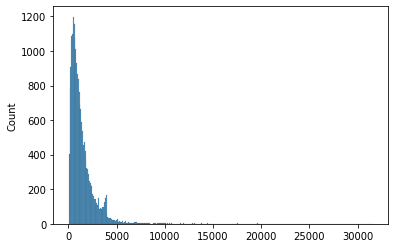

In [20]:
# Write your code here to visualise the data according to the 'Complaint' character length
list_ = []

for i in df_clean['complaint_what_happened']:
  list_.append(len(i))

sns.histplot(list_)

#### Find the top 40 words by frequency among all the articles after processing the text.

i
chase
account
xxxx
credit
wa
card
bank
payment
time
day
xxxxxxxx
charge
money
loan
check
letter
information
fee
transaction
number
month
amount
year
mortgage
customer
ha
balance
company
service
phone
report
fraud
claim
fund
call
business
interest
statement
home


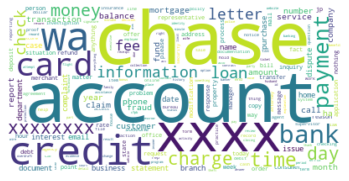

In [21]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text

text = []

for i in df_clean['complaint_POS_removed']:
  text.append(i)

text = ' '.join(text)

words = nltk.word_tokenize(text)
x = Counter(words)

for i in x.most_common(40):
  print(i[0])


word_cloud = wordcloud.WordCloud(collocations = False, background_color = 'white').generate(text)

plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [22]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')
df_clean

# This code is of no effect as we have not taken any words with PRON tag since we have only taken NN tag

,complaint_what_happened,lematized_complaints,complaint_POS_removed,Complaint_clean
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...,morning name stop bank cardmember service debt...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and wa told by...,i card agent upgrade date agent wa information...,i card agent upgrade date agent wa information...
10,Chase Card was reported on XX/XX/2019. However...,chase card wa reported on however fraudulent a...,card wa application identity consent service c...,card wa application identity consent service c...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket i c...,book xxxx ticket i offer ticket card i informa...,book xxxx ticket i offer ticket card i informa...
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for 160000 i deposi...,son deposit chase account fund chase bank acco...,son deposit chase account fund chase bank acco...
...,...,...,...,...
78303,After being a Chase Card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade wa solicitation cre...,chase card customer decade wa solicitation cre...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx i called chas my xxxx xx...,xxxxxxxx i chas visa credit card provider clai...,xxxxxxxx i chas visa credit card provider clai...
78310,I am not familiar with XXXX pay and did not un...,i am not familiar with xxxx pay and did not un...,i pay risk consumer i bank app chase year mobi...,i pay risk consumer i bank app chase year mobi...
78311,I have had flawless credit for 30 yrs. I've ha...,i have had flawless credit for 30 yr ive had c...,i credit credit card chase freedom xxxx proble...,i credit credit card chase freedom xxxx proble...


#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [23]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
unigrams = ngrams(text.split(), 1)

x = Counter(unigrams)

x.most_common(30)

[(('i',), 127688),
 (('chase',), 51161),
 (('account',), 47649),
 (('xxxx',), 39572),
 (('credit',), 33094),
 (('wa',), 32595),
 (('card',), 29608),
 (('bank',), 28233),
 (('payment',), 21167),
 (('time',), 16038),
 (('day',), 12972),
 (('xxxxxxxx',), 12834),
 (('charge',), 12245),
 (('money',), 11961),
 (('loan',), 10982),
 (('check',), 10190),
 (('letter',), 9669),
 (('information',), 9654),
 (('fee',), 8701),
 (('transaction',), 8650),
 (('number',), 8604),
 (('month',), 8463),
 (('amount',), 8366),
 (('year',), 8292),
 (('mortgage',), 8179),
 (('customer',), 8163),
 (('ha',), 8147),
 (('balance',), 7763),
 (('company',), 7630),
 (('service',), 7596)]

In [24]:
#Print the top 10 words in the unigram frequency
for i in x.most_common(10):
  print(i[0][0])

i
chase
account
xxxx
credit
wa
card
bank
payment
time


In [25]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
bigrams = ngrams(text.split(), 2)

x = Counter(bigrams)

x.most_common(30)

[(('credit', 'card'), 12804),
 (('i', 'chase'), 7625),
 (('i', 'i'), 6409),
 (('xxxx', 'i'), 6373),
 (('account', 'i'), 5787),
 (('xxxxxxxx', 'i'), 4969),
 (('xxxx', 'xxxx'), 4417),
 (('i', 'account'), 4199),
 (('credit', 'report'), 3871),
 (('i', 'credit'), 3630),
 (('card', 'i'), 3627),
 (('i', 'bank'), 3595),
 (('i', 'xxxx'), 3387),
 (('i', 'payment'), 3097),
 (('customer', 'service'), 3078),
 (('chase', 'credit'), 3009),
 (('chase', 'i'), 2892),
 (('chase', 'account'), 2837),
 (('chase', 'bank'), 2835),
 (('wa', 'i'), 2796),
 (('account', 'wa'), 2729),
 (('bank', 'account'), 2710),
 (('account', 'chase'), 2390),
 (('i', 'card'), 2264),
 (('payment', 'i'), 2234),
 (('time', 'i'), 2216),
 (('i', 'letter'), 2071),
 (('i', 'wa'), 2012),
 (('account', 'account'), 1911),
 (('bank', 'i'), 1819)]

In [26]:
#Print the top 10 words in the bigram frequency
for i in x.most_common(10):
  print(i[0])

('credit', 'card')
('i', 'chase')
('i', 'i')
('xxxx', 'i')
('account', 'i')
('xxxxxxxx', 'i')
('xxxx', 'xxxx')
('i', 'account')
('credit', 'report')
('i', 'credit')


In [27]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
trigrams = ngrams(text.split(), 3)

x = Counter(trigrams)

x.most_common(30)

[(('chase', 'credit', 'card'), 2082),
 (('i', 'credit', 'card'), 1691),
 (('credit', 'card', 'i'), 1244),
 (('credit', 'card', 'account'), 1009),
 (('credit', 'card', 'company'), 981),
 (('xxxx', 'xxxx', 'i'), 793),
 (('i', 'customer', 'service'), 747),
 (('credit', 'card', 'chase'), 609),
 (('xxxx', 'xxxx', 'xxxx'), 542),
 (('i', 'account', 'i'), 536),
 (('inquiry', 'credit', 'report'), 511),
 (('i', 'chase', 'credit'), 475),
 (('i', 'xxxx', 'i'), 459),
 (('account', 'i', 'chase'), 459),
 (('xxxxxxxx', 'i', 'chase'), 451),
 (('credit', 'report', 'i'), 446),
 (('i', 'chase', 'i'), 437),
 (('xxxx', 'i', 'chase'), 431),
 (('i', 'letter', 'chase'), 407),
 (('i', 'xxxx', 'xxxx'), 403),
 (('i', 'payment', 'i'), 401),
 (('credit', 'reporting', 'agency'), 388),
 (('i', 'chase', 'account'), 382),
 (('credit', 'card', 'credit'), 379),
 (('account', 'i', 'account'), 370),
 (('i', 'chase', 'bank'), 369),
 (('i', 'bank', 'account'), 368),
 (('bank', 'credit', 'card'), 362),
 (('account', 'credit',

In [28]:
#Print the top 10 words in the trigram frequency
for i in x.most_common(10):
  print(i[0])

('chase', 'credit', 'card')
('i', 'credit', 'card')
('credit', 'card', 'i')
('credit', 'card', 'account')
('credit', 'card', 'company')
('xxxx', 'xxxx', 'i')
('i', 'customer', 'service')
('credit', 'card', 'chase')
('xxxx', 'xxxx', 'xxxx')
('i', 'account', 'i')


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [29]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xx/xx','')
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xx','')

In [30]:
#All masked texts has been removed
df_clean

,complaint_what_happened,lematized_complaints,complaint_POS_removed,Complaint_clean
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...,morning name stop bank cardmember service debt...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and wa told by...,i card agent upgrade date agent wa information...,i card agent upgrade date agent wa information...
10,Chase Card was reported on XX/XX/2019. However...,chase card wa reported on however fraudulent a...,card wa application identity consent service c...,card wa application identity consent service c...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket i c...,book xxxx ticket i offer ticket card i informa...,book ticket i offer ticket card i information...
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for 160000 i deposi...,son deposit chase account fund chase bank acco...,son deposit chase account fund chase bank acco...
...,...,...,...,...
78303,After being a Chase Card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade wa solicitation cre...,chase card customer decade wa solicitation cre...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx i called chas my xxxx xx...,xxxxxxxx i chas visa credit card provider clai...,i chas visa credit card provider claim purcha...
78310,I am not familiar with XXXX pay and did not un...,i am not familiar with xxxx pay and did not un...,i pay risk consumer i bank app chase year mobi...,i pay risk consumer i bank app chase year mobi...
78311,I have had flawless credit for 30 yrs. I've ha...,i have had flawless credit for 30 yr ive had c...,i credit credit card chase freedom xxxx proble...,i credit credit card chase freedom problem ba...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [31]:
#Write your code here to initialise the TfidfVectorizer 

tfidf = TfidfVectorizer(max_df=0.95, min_df=2, max_features=5000, ngram_range=(1, 2))

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [32]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.

doc_vec = tfidf.fit_transform(df_clean['Complaint_clean'])

pd.DataFrame(doc_vec.toarray(), columns=tfidf.get_feature_names())

,ability,ability credit,above,abuse,ac,acceptance,access,access account,access bank,access card,...,year time,year wa,year year,yesterday,york,youre,yr,zero,zip,zip code
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [33]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [34]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components=num_topics,
                init='nndsvd',
                max_iter=500,
                l1_ratio=0.0,
                solver='cd',
                alpha=0.0,
                tol=1e-4,
                random_state=40)

In [35]:
nmf_model.fit(doc_vec)
len(tfidf.get_feature_names())

W = nmf_model.fit_transform(doc_vec)
H = nmf_model.components_

In [36]:
#Print the Top15 words for each of the topics

words = np.array(tfidf.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,bank,check,money,chase,wa,fund,transaction,day,branch,deposit,claim,bank account,number,fraud
Topic 2,card,credit,credit card,charge,chase,wa,chase credit,dispute,purchase,company,service,merchant,fraud,time,card chase
Topic 3,loan,mortgage,chase,home,modification,property,wa,year,letter,document,time,foreclosure,sale,rate,house
Topic 4,credit,report,inquiry,credit report,inquiry credit,bureau,credit bureau,account,reporting,debt,score,information,report credit,account credit,identity
Topic 5,payment,balance,fee,payment payment,interest,month,payment wa,statement,amount,chase payment,wa,payment account,payment chase,time,day


In [37]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_mapping = {
    'Topic 1': 0,
    'Topic 2': 1,
    'Topic 3': 2,
    'Topic 4': 3,
    'Topic 5': 4
}


In [38]:
W = pd.DataFrame(W, columns=[f'Topic {i + 1}' for i in range(num_topics)])
W['max_topic'] = W.apply(lambda x: topic_mapping.get(x.idxmax()), axis=1)
W[pd.notnull(W['max_topic'])].head(10)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,max_topic
0,0.020751,0.002556,0.015980,0.013638,0.004193,0
1,0.009132,0.015301,0.004888,0.001100,0.002183,1
2,0.000000,0.031572,0.000000,0.018431,0.000000,1
3,0.018786,0.024494,0.017555,0.051738,0.000000,3
4,0.060820,0.000000,0.002175,0.000000,0.000000,0
5,0.000000,0.000000,0.000000,0.108485,0.000000,3
6,0.057328,0.003969,0.007656,0.000000,0.010265,0
7,0.004645,0.006437,0.037763,0.000000,0.048727,4
8,0.036938,0.019868,0.020370,0.001638,0.002375,0
9,0.000000,0.055809,0.000000,0.078467,0.000000,3


In [39]:
#Assign the best topic to each of the cmplaints in Topic Column
df_clean['Topic'] = W['max_topic']

In [40]:
df_clean.head()

,complaint_what_happened,lematized_complaints,complaint_POS_removed,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...,morning name stop bank cardmember service debt...,1.0
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and wa told by...,i card agent upgrade date agent wa information...,i card agent upgrade date agent wa information...,1.0
10,Chase Card was reported on XX/XX/2019. However...,chase card wa reported on however fraudulent a...,card wa application identity consent service c...,card wa application identity consent service c...,0.0
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket i c...,book xxxx ticket i offer ticket card i informa...,book ticket i offer ticket card i information...,3.0
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for 160000 i deposi...,son deposit chase account fund chase bank acco...,son deposit chase account fund chase bank acco...,1.0


In [41]:
#Print the first 5 Complaint for each of the Topics
df_group=df_clean.groupby('Topic').head(10)
df_group.sort_values('Topic')

,complaint_what_happened,lematized_complaints,complaint_POS_removed,Complaint_clean,Topic
58,I made a purchase of {$260.00} on XX/XX/XXXX. ...,i made a purchase of 26000 on xxxxxxxx i made ...,i purchase xxxxxxxx i payment xxxxxxxx payment...,i purchase i payment payment wa closing date...,0.0
10,Chase Card was reported on XX/XX/2019. However...,chase card wa reported on however fraudulent a...,card wa application identity consent service c...,card wa application identity consent service c...,0.0
69,Someone called stating I had felony committed ...,someone called stating i had felony committed ...,someone i felony security number name account ...,someone i felony security number name account ...,0.0
65,I opened the Chase/XXXX XXXX Rewards credit ca...,i opened the chasexxxx xxxx reward credit card...,i chasexxxx reward credit card time offer rewa...,i chase reward credit card time offer reward p...,0.0
15,Can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,0.0
17,With out notice J.P. Morgan Chase restricted m...,with out notice jp morgan chase restricted my ...,jp chase account debit card tuesday thursday b...,jp chase account debit card tuesday thursday b...,0.0
64,Chase is marketing credit cards to those of us...,chase is marketing credit card to those of u w...,chase credit card credit style marketing swa c...,chase credit card credit style marketing swa c...,0.0
52,My roommate was stealing my Chase debit card a...,my roommate wa stealing my chase debit card an...,roommate wa chase debit card driver license mo...,roommate wa chase debit card driver license mo...,0.0
45,I made a purchase with XXXX XXXX XXXX on XX/XX...,i made a purchase with xxxx xxxx xxxx on in th...,i purchase amount i transaction i dispute case...,i purchase amount i transaction i dispute case...,0.0
43,Chase sent me an email today with the innocuou...,chase sent me an email today with the innocuou...,chase email today title information change cha...,chase email today title information change cha...,0.0


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [42]:
#Create the dictionary of Topic names and Topics
# Upon Reading the complaints, these were the best assignments
Topic_names = {0: 'Theft/Dispute Reporting',
               1: 'Bank Account services',
               2: 'Credit card or prepaid card', 
               3: 'Others',
               4: 'Mortgage/Loan'
               }
               
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [43]:
df_clean

,complaint_what_happened,lematized_complaints,complaint_POS_removed,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...,morning name stop bank cardmember service debt...,Bank Account services
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and wa told by...,i card agent upgrade date agent wa information...,i card agent upgrade date agent wa information...,Bank Account services
10,Chase Card was reported on XX/XX/2019. However...,chase card wa reported on however fraudulent a...,card wa application identity consent service c...,card wa application identity consent service c...,Theft/Dispute Reporting
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket i c...,book xxxx ticket i offer ticket card i informa...,book ticket i offer ticket card i information...,Others
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for 160000 i deposi...,son deposit chase account fund chase bank acco...,son deposit chase account fund chase bank acco...,Bank Account services
...,...,...,...,...,...
78303,After being a Chase Card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade wa solicitation cre...,chase card customer decade wa solicitation cre...,NaN
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx i called chas my xxxx xx...,xxxxxxxx i chas visa credit card provider clai...,i chas visa credit card provider claim purcha...,NaN
78310,I am not familiar with XXXX pay and did not un...,i am not familiar with xxxx pay and did not un...,i pay risk consumer i bank app chase year mobi...,i pay risk consumer i bank app chase year mobi...,NaN
78311,I have had flawless credit for 30 yrs. I've ha...,i have had flawless credit for 30 yr ive had c...,i credit credit card chase freedom xxxx proble...,i credit credit card chase freedom problem ba...,NaN


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [44]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[['complaint_what_happened', 'Topic']]


#Using integers for the models
label_names = {'Theft/Dispute Reporting' : 0,
               'Bank Account services' : 1,
               'Credit card or prepaid card' : 2, 
               'Others' : 3,
               'Mortgage/Loan' : 4
               }

training_data['Topic'] = training_data['Topic'].map(label_names)

In [45]:
training_data

,complaint_what_happened,Topic
1,Good morning my name is XXXX XXXX and I apprec...,1.0
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,1.0
10,Chase Card was reported on XX/XX/2019. However...,0.0
11,"On XX/XX/2018, while trying to book a XXXX XX...",3.0
14,my grand son give me check for {$1600.00} i de...,1.0
...,...,...
78303,After being a Chase Card customer for well ove...,NaN
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",NaN
78310,I am not familiar with XXXX pay and did not un...,NaN
78311,I have had flawless credit for 30 yrs. I've ha...,NaN


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [46]:
#Write your code to get the Vector count
vectorizer = CountVectorizer(analyzer='word',
                             ngram_range=(1, 1),
                             max_features=500,
                             max_df=0.95, 
                             min_df=2
                            )  
document = vectorizer.fit_transform(training_data['complaint_what_happened'])

#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)
doc_vec = tfidf_transformer.fit_transform(document)
tfidf_df = pd.DataFrame(doc_vec.toarray(),
             columns=vectorizer.get_feature_names())
tfidf_df['label'] = training_data['Topic']

tfidf_df = tfidf_df[tfidf_df['label'].notna()]

tfidf_df

,00,10,15,20,2016,2018,2019,2020,30,able,...,written,wrong,xx,xxxx,year,years,yet,you,your,label
1,0.000000,0.000000,0.0,0.0,0.0,0.164203,0.000000,0.0,0.0,0.000000,...,0.0,0.155494,0.420196,0.285899,0.000000,0.000000,0.0,0.000000,0.0,1.0
2,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.260279,0.0,0.0,0.000000,...,0.0,0.000000,0.222606,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.0
10,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.211235,0.000000,0.000000,0.0,0.000000,0.0,0.0
11,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.107674,0.0,0.0,0.082278,...,0.0,0.000000,0.092089,0.031329,0.000000,0.000000,0.0,0.000000,0.0,3.0
14,0.079105,0.052846,0.0,0.0,0.0,0.000000,0.059001,0.0,0.0,0.000000,...,0.0,0.000000,0.050461,0.171667,0.000000,0.000000,0.0,0.000000,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21057,0.111919,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.214177,0.255019,0.000000,0.000000,0.0,0.000000,0.0,1.0
21058,0.000000,0.073901,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.070565,0.264065,0.000000,0.000000,0.0,0.000000,0.0,0.0
21062,0.038339,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.131103,...,0.0,0.000000,0.000000,0.174718,0.000000,0.000000,0.0,0.105167,0.0,0.0
21068,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.098105,0.116813,0.046519,0.000000,0.0,0.000000,0.0,1.0


In [47]:
train = tfidf_df.copy()
del train['label']
test = tfidf_df['label']

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(train,
                                                                            test,
                                                                            test_size=0.2)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [48]:
def get_metrics(y_true, y_predict):
  print('accuracy: ', sklearn.metrics.accuracy_score(y_true, y_predict))
  print('F1 Score: ', sklearn.metrics.f1_score(y_true, y_predict, average='micro'))

In [49]:
# Write your code here to build any 3 models and evaluate them using the required metrics


#Decision Tree Classifier Model

from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=15, max_features=500, random_state=20)
clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

get_metrics(y_test, y_pred)

accuracy:  0.775438596491228
F1 Score:  0.7754385964912279


In [50]:
#Random Forests Model

from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=50, max_depth=20, max_features=500, random_state=20)
rfc = rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

get_metrics(y_test, y_pred)

accuracy:  0.8414035087719298
F1 Score:  0.8414035087719298


In [51]:
#Naive Bayes Model

from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
mnb = mnb.fit(X_train, y_train)

y_pred = mnb.predict(X_test)

get_metrics(y_test, y_pred)

accuracy:  0.7866666666666666
F1 Score:  0.7866666666666666


### Conclusion

Based on the above scores, the Random Forest Classifier seems to be performing the best